Can we use machine learning to tell us more about the system?

In [54]:
%pylab inline

from hdbscan import HDBSCAN
import fitsio
import toyplot
from astropy.stats import sigma_clip
import sys
sys.path.insert(0, '..')
from binmodule import fast_bin
import seaborn as sns
from scipy.stats import spearmanr

sns.set(palette='Set2', context='poster')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
fname = '../data/20150911-ng2000-802-custom-flat-high-quality.fits'

In [3]:
with fitsio.FITS(fname) as infile:
    flux = infile['tamflux'].read()
    ccdx = infile['ccdx'].read()
    ccdy = infile['ccdy'].read()
    imagelist = infile['imagelist'].read()

In [4]:
with fitsio.FITS('../ng2000-matched-catalogue.fits') as infile:
    cat = infile[1].read()
    
rmag = cat['r1mag_ppmxl']

In [5]:
def compute_frms(flux):
    med_flux = np.median(flux, axis=1)
    mad_flux = np.median(np.abs(flux - med_flux[:, np.newaxis]), axis=1)
    frms = 1.48 * mad_flux / med_flux
    return med_flux, mad_flux, frms

In [6]:
bin_value = 100
binned_flux = fast_bin(sigma_clip(flux, axis=1), bin_value)

In [7]:
med_flux, mad_flux, frms = compute_frms(binned_flux)
ind = (med_flux > 0) & (frms > 0)

(18, 6)

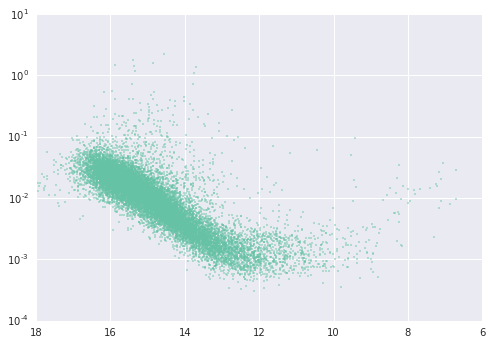

In [8]:
plt.semilogy(rmag[ind], frms[ind], '.', ms=3)
plt.xlim(18, 6)

In [70]:
chosen_ind = (rmag > 10) & (rmag < 12) & ind & (frms < 4E-3)

ValueError: operands could not be broadcast together with shapes (18910,) (508,) 

In [71]:
rmag_sample, flux_sample, ccdx_sample, ccdy_sample = [data[chosen_ind] for data in [rmag, binned_flux, ccdx, ccdy]]
print(flux_sample.shape)

(508, 18)


In [72]:
med_sample, mad_sample, frms_sample = compute_frms(flux_sample)

## Positional changes

Now we characterise the location on the chip, and distance traveled.

In [73]:
skip = 30
med_x, med_y = [np.median(data[:, skip:], axis=1) for data in [ccdx_sample, ccdy_sample]]
percentiles_x, percentiles_y = [np.percentile(data, [5, 95], axis=1) for data in [ccdx_sample, ccdy_sample]]
distance_x, distance_y = [np.abs(data.ptp(axis=0)) for data in [percentiles_x, percentiles_y]]

## Flux features

Now we look at some extracted flux features

* spearman-rank coefficient
* linear fit gradient

In [74]:
frames = np.arange(flux_sample.shape[1])
sc = np.array([spearmanr(frames, lc)[0] for lc in flux_sample])

In [76]:
gradients = np.array([np.polyfit(frames, lc, 1)[0] for lc in flux_sample])

In [89]:
X = np.stack([med_x, med_y, distance_x, distance_y, sc, gradients, frms_sample]).T

In [90]:
model = HDBSCAN()
labels = model.fit_predict(X)

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


In [91]:
labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  2, -1, -1, -1, -1, -1, 12, -1, 12, 12, -1, 12, -1,  2, 12, 12,
       -1, 12, 12, 12, 12,  2, 12,  2, 12,  8, -1,  2,  2, -1, -1,  2,  2,
       14, 12, 12, -1, 12, -1, -1, -1,  2,  2, 12, 14, 14, -1,  8, -1, 14,
       -1,  8,  8,  2, 12, -1,  4, 14, -1, 14, -1, 14, -1, 12, -1, -1, 12,
       15, -1, -1,  8, 13, 13,  4, -1, 13, -1, 14,  4, 13, 12, 14, 13, 13,
       15, 15, -1, -1, -1,  4, -1, -1, -1,  8, -1, -1, 13, 12, 13,  4, 13,
       -1, -1, -1, 13, 12, -1, -1, -1, 13, -1, -1, -1,  4, 13,  4, -1, 15,
       15, 12, 15, 12, -1, -1, 13, -1,  4, 13,  4,  4, -1, 15, 12, -1, 15,
       -1, 11, -1, -1,  4, -1, -1, -1, -1, -1, -1,  4, -1, -1, -1, -1, -1,
       -1, -1, 11, -1,  4, -1, -1,  4,  4, 11, -1,  4, -1, -1,  6, 11, -1,
       11, 11, -1, 11, -1,  4, 11,  4,  4, -1, 11,  6,  6, -1, -1,  6, -1,
       11,  4,  6, 11,  4,  4, -1, -1, -1,  9, 11,  6, 11, -1,  4,  6, -1,
       -1,  6,  6,  6, -1

In [92]:
unique_labels = np.sort(np.unique(labels))

In [93]:
palette = sns.color_palette('deep', unique_labels.max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

(0, 0.005)

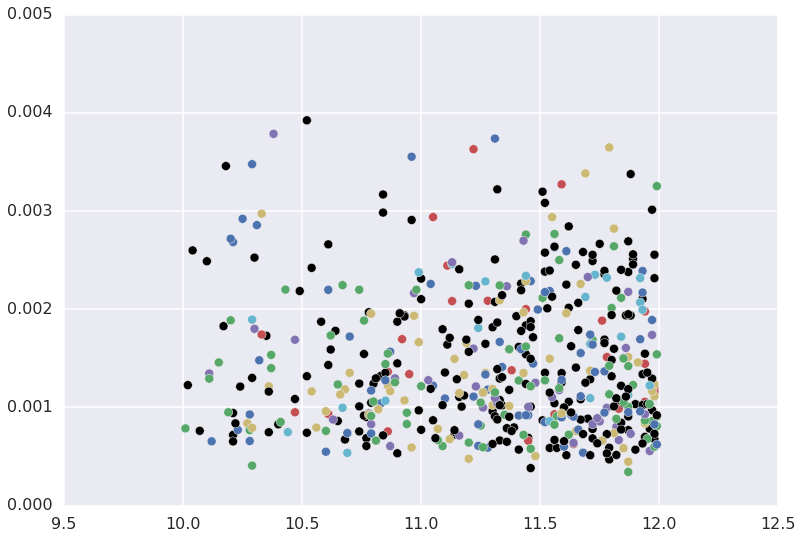

In [99]:
plt.scatter(rmag_sample, frms_sample, c=colors, s=80)
# plt.yscale('log')
plt.ylim(0, 0.005)

In [45]:
groups = []
for label in unique_labels:
    ind = labels == label
    sample = frms_sample[ind]
    groups.append(sample)

''

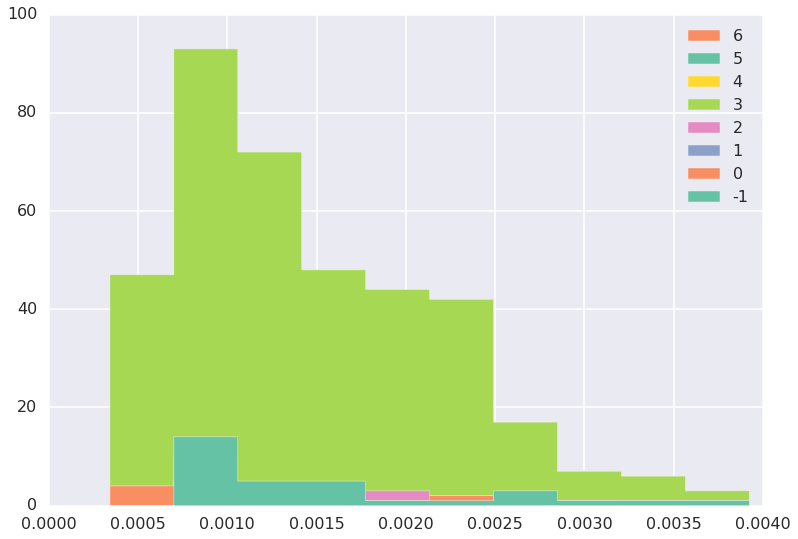

In [55]:
plt.hist(groups, histtype='stepfilled', label=unique_labels)
plt.legend(loc='best')
;